## Calculating return period for cyclones in Mozambique

We're looking to calculate the return period for cyclones of a given threshold speed over select provinces in Mozambique. We'd like to have both: 
- An overall return period across all selected provinces
- A per-province return period

In [75]:
%load_ext jupyter_black
import geopandas as gpd
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from shapely.geometry import LineString
import os
from datetime import datetime
import matplotlib.pyplot as plt
import math

load_dotenv()
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
AA_DATA_DIR_NEW = os.getenv("AA_DATA_DIR_NEW")
# https://en.wikipedia.org/wiki/Tropical_cyclone_scales#South-West_Indian_Ocean

THRESHOLD_SPEED_OPT1 = 89
THRESHOLD_SPEED_OPT2 = 118
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## 1. Data loading and preparation

We'll start by loading in the required data sources below. We need the ADM1 boundaries (provinces) and the [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive) `.shp` of cyclone tracks. We'll select only the provinces of interest from the admin boundaries file.

In [76]:
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]

# TODO: Replace with local path
ibtracs_path = adm1_path = Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
lines_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.lines/IBTrACS.SI.list.v04r01.lines.shp"
)

gdf_points = gpd.read_file(points_path)
gdf_lines = gpd.read_file(lines_path)

In [77]:
# TODO: Some additional data shared from Tristan that might be useful
# wmo_speeds_path = Path(AA_DATA_DIR_NEW) / "public" / "processed" / "glb" / "ibtracs" / "ibtracs_with_wmo_wind.parquet"
# df_wmo_speeds = pd.read_parquet(wmo_speeds_path)

Let's also check that both datasets have the same CRS. Then we can select only the points within the polygons. We'll also clean up the columns and make sure points are sorted by time.

In [78]:
assert gdf_points.crs == gdf_sel.crs == gdf_lines.crs
gdf_points_sel = gpd.sjoin(gdf_points, gdf_sel, how="inner", predicate="intersects")
gdf_lines_sel = gpd.sjoin(gdf_lines, gdf_sel, how="inner", predicate="intersects")
gdf_points_sel_ = gdf_points_sel[
    ["ADM1_PT", "NAME", "ISO_TIME", "REU_WIND", "WMO_WIND", "USA_WIND", "geometry"]
].sort_values("ISO_TIME")

And plot for a basic sanity check

<Axes: >

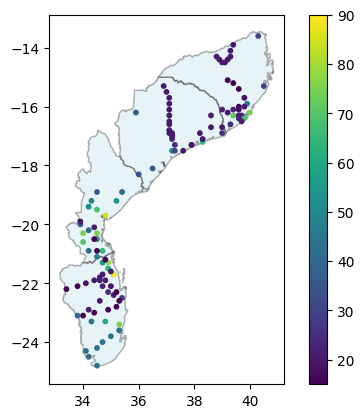

In [79]:
ax = gdf_sel.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

Now we also want to get the maximum speed per storm track. 

**TODO: Interpolate to greater temporal frequency (eg. 30 mins)**

In [80]:
lines = []
for name, group in gdf_points_sel_.groupby("NAME"):
    # TODO: Interpolate to avoid groups of only 1 point
    if len(group) > 1:
        line = LineString(group["geometry"].tolist())
        lines.append(
            {"NAME": name, "geometry": line, "max_speed": group["REU_WIND"].max()}
        )

gdf_tracks_joined = gpd.GeoDataFrame(lines, crs="EPSG:4326")

And plot again to sanity check

<Axes: >

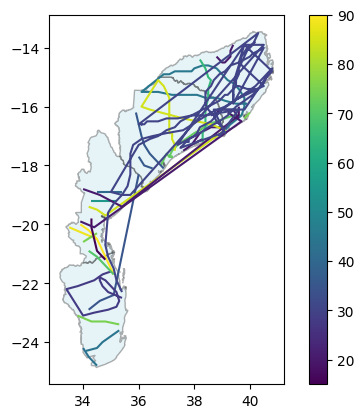

In [81]:
ax = gdf_sel.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_tracks_joined.plot(ax=ax, column="max_speed", markersize=10, legend=True)

## 2. Return period calculation

How often do storms reach 80km/hr within these provinces?

In [82]:
# combining US Wind and REUnion for those with no wind speed
gdf_points_sel_["REU_USA_WIND"] = gdf_points_sel_["REU_WIND"].fillna(
    gdf_points_sel_["USA_WIND"] * 0.88
)

In [83]:
df = gdf_points_sel_[
    gdf_points_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1998
]
df["NAME"].unique()

array(['UNNAMED', 'BELTANE', 'ASTRIDE', 'ELINE:LEONE', 'GLORIA', 'HUDAH',
       'DELFINA', 'JAPHET', 'FAVIO', 'JOKWE', 'IZILDA', 'DANDO', 'IRINA',
       'HARUNA', 'DELIWE', 'GUITO', 'HELLEN', 'CHEDZA', 'DINEO',
       'DESMOND', 'IDAI', 'KENNETH', 'CHALANE', 'ELOISE', 'GUAMBE', 'ANA',
       'GOMBE', 'JASMINE', 'FREDDY', 'FILIPO'], dtype=object)

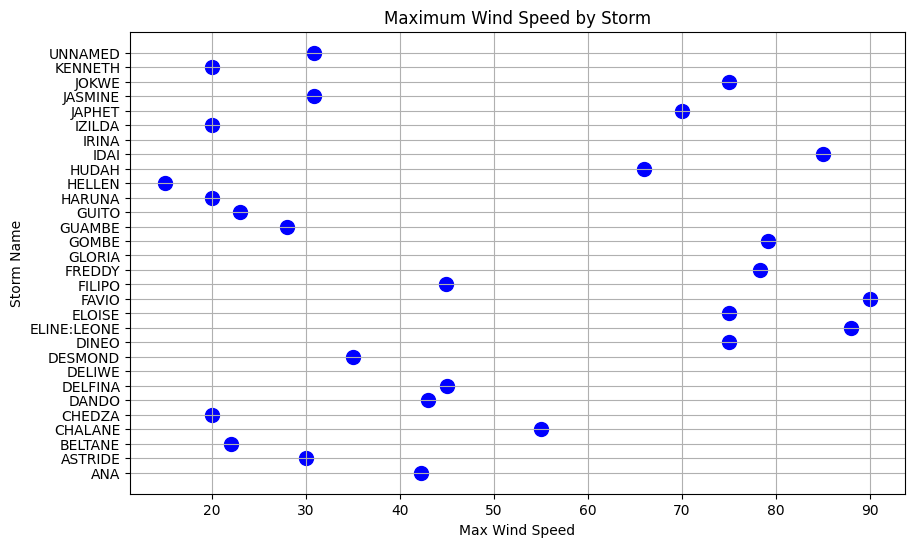

In [84]:
max_values = df.groupby("NAME")["REU_USA_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 6))
plt.scatter(
    max_values["REU_USA_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed")
plt.title("Maximum Wind Speed by Storm")
plt.grid(True)
plt.show()

In [85]:
def calculate_storm_return_period(df, wind_speed_kmh, start_year, num_storms_year):
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[(df["year"] >= start_year) & (df["REU_USA_WIND"] >= speed_knots)]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2022 - start_year + 1

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # Calculate return periods for each admin region
    admin_return_periods = {}

    grouped = df_filtered.groupby("ADM1_PT")
    for admin, group in grouped:
        admin_unique_storms = group["NAME"].nunique()
        # admin_yr_len = max(group["year"]) - min(group["year"]) + 1
        admin_return_period = yr_len / admin_unique_storms
        admin_return_periods[admin] = admin_return_period

        print(
            f"The return period of storms over {wind_speed_kmh}km/h in {admin} is 1-in-{round(admin_return_period, 1)} years."
        )

    # http://hurricanepredictor.com/Methodology/USmethodology.pdf
    # Trying out the methodology above
    # using Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        * math.factorial(num_storms_year)
    )
    print(
        f"The probability of exactly {num_storms_year} making landfall in an average year is {round(expected_probability *100, 1)} %."
    )
    print(
        f"The return period of exactly {num_storms_year} making landfall in an average year is 1-in-{round(1 / expected_probability, 1)} years."
    )

In [86]:
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh=THRESHOLD_SPEED_OPT1,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 89km/h is 1-in-3.1 years.
The return period of storms over 89km/h in Inhambane is 1-in-14.3 years.
The return period of storms over 89km/h in Nampula is 1-in-14.3 years.
The return period of storms over 89km/h in Sofala is 1-in-6.1 years.
The return period of storms over 89km/h in Zambezia is 1-in-14.3 years.
The probability of exactly 1 making landfall in an average year is 23.5 %.
The return period of exactly 1 making landfall in an average year is 1-in-4.3 years.


In [87]:
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh=THRESHOLD_SPEED_OPT1,
    start_year=1998,
    num_storms_year=1,
)

The combined return period of storms over 89km/h is 1-in-2.3 years.
The return period of storms over 89km/h in Inhambane is 1-in-8.3 years.
The return period of storms over 89km/h in Nampula is 1-in-12.5 years.
The return period of storms over 89km/h in Sofala is 1-in-5.0 years.
The return period of storms over 89km/h in Zambezia is 1-in-12.5 years.
The probability of exactly 1 making landfall in an average year is 28.3 %.
The return period of exactly 1 making landfall in an average year is 1-in-3.5 years.


In [88]:
calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh=THRESHOLD_SPEED_OPT2,
    start_year=1980,
    num_storms_year=1,
)

The combined return period of storms over 118km/h is 1-in-3.6 years.
The return period of storms over 118km/h in Inhambane is 1-in-14.3 years.
The return period of storms over 118km/h in Nampula is 1-in-14.3 years.
The return period of storms over 118km/h in Sofala is 1-in-10.8 years.
The return period of storms over 118km/h in Zambezia is 1-in-14.3 years.
The probability of exactly 1 making landfall in an average year is 21.1 %.
The return period of exactly 1 making landfall in an average year is 1-in-4.7 years.


## Looking at the historical impact of cyclones

In [89]:
def calculate_storm_expected_probability(
    df, wind_speed_kmh, start_year, num_storms_year
):
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[(df["year"] >= start_year) & (df["REU_USA_WIND"] >= speed_knots)]

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the total number of years in the filtered DataFrame
    yr_len = 2022 - start_year + 1

    # Calculate the combined return period
    # http://hurricanepredictor.com/Methodology/USmethodology.pdf
    # Trying out the methodology above
    # using Poisson distribution
    ave_num = unique_storms / yr_len
    expected_probability = (
        math.exp(-ave_num)
        * (ave_num**num_storms_year)
        * math.factorial(num_storms_year)
    )
    return expected_probability

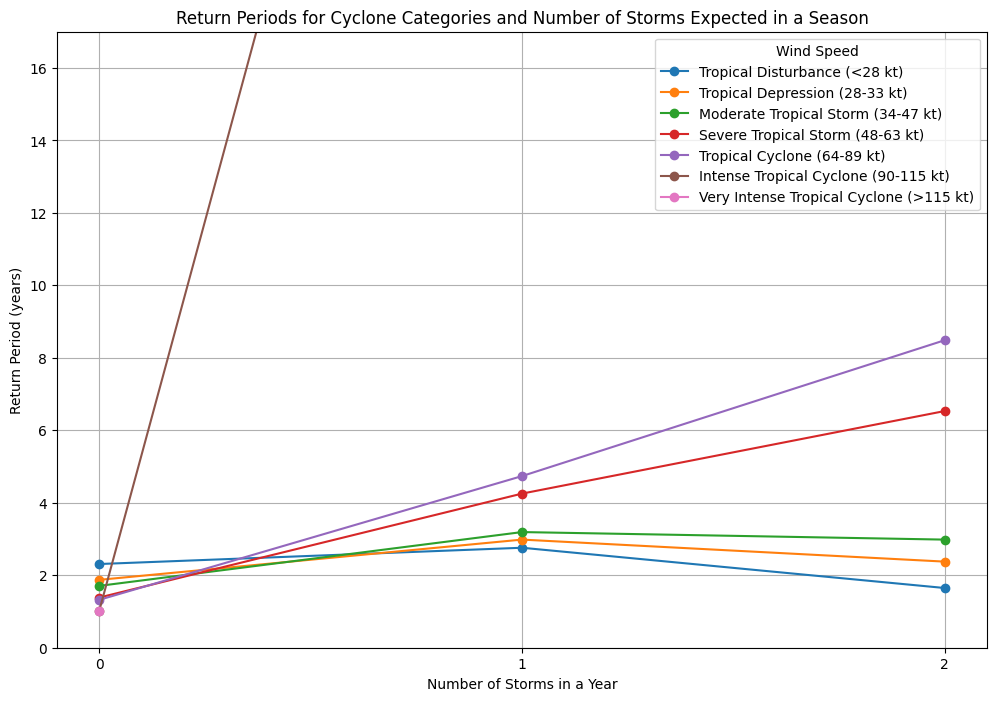

In [90]:
# Define parameters
wind_speeds = [1, 51, 63, 89, 118, 166, 212]  # List of wind speeds in km/h
storm_numbers = range(0, 3)  # Number of storms
start_year = 1980
# Define wind speed categories
wind_speed_categories = {
    1: "Tropical Disturbance (<28 kt)",
    51: "Tropical Depression (28-33 kt)",
    63: "Moderate Tropical Storm (34-47 kt)",
    89: "Severe Tropical Storm (48-63 kt)",
    118: "Tropical Cyclone (64-89 kt)",
    166: "Intense Tropical Cyclone (90-115 kt)",
    212: "Very Intense Tropical Cyclone (>115 kt)",
}
# Prepare to plot
plt.figure(figsize=(12, 8))

# Calculate and plot return periods for each wind speed
for wind_speed in wind_speeds:
    return_periods = []
    for storm_num in storm_numbers:
        expected_probability = calculate_storm_expected_probability(
            df=gdf_points_sel_,
            wind_speed_kmh=wind_speed,
            start_year=start_year,
            num_storms_year=storm_num,
        )

        # Calculate return period from expected probability
        if expected_probability > 0:
            return_period = 1 / expected_probability
        else:
            return_period = float("inf")  # Handle case where probability is zero

        return_periods.append(return_period)
    label = wind_speed_categories.get(wind_speed, f"{wind_speed} km/h")
    plt.plot(storm_numbers, return_periods, marker="o", label=label)

# Add plot details
plt.xlabel("Number of Storms in a Year")
plt.ylabel("Return Period (years)")
plt.ylim(0, 17)
plt.title(
    "Return Periods for Cyclone Categories and Number of Storms Expected in a Season"
)
plt.legend(title="Wind Speed")
plt.xticks(ticks=range(min(storm_numbers), max(storm_numbers) + 1))

plt.grid(True)
plt.show()